# Introduction to `pypsa`

:::{note}
This material is mostly adapted from the following resources:
- [Data Science for Energy System Modelling: Introduction to PyPSA](https://fneum.github.io/data-science-for-esm/09-workshop-pypsa.html)
:::

<img src="https://github.com/fneum/data-science-for-esm/raw/main/data-science-for-esm/pypsa-logo.png" width="300px" />

PyPSA stands for **Python for Power System Analysis**.

PyPSA is an open source Python package for simulating and optimising modern energy systems that include features such as

- conventional generators with unit commitment (ramp-up, ramp-down, start-up, shut-down),
- time-varying wind and solar generation,
- energy storage with efficiency losses and inflow/spillage for hydroelectricity
- coupling to other energy sectors (electricity, transport, heat, industry),
- conversion between energy carriers (e.g. electricity to hydrogen),
- transmission networks (AC, DC, other fuels)

PyPSA can be used for a variety of problem types (e.g. electricity market modelling, long-term investment planning, transmission network expansion planning), and is designed to scale well with large networks and long time series.

Compared to building power system by hand in `linopy`, PyPSA does the following things for you:

- manage data inputs
- build optimisation problem
- communicate with the solver
- retrieve and process optimisation results
- manage data outputs

### Dependencies

- `pandas` for storing data about network components and time series
- `numpy` and `scipy` for linear algebra and sparse matrix calculations
- `matplotlib` and `cartopy` for plotting on a map
- `networkx` for network calculations
- `linopy` for handling optimisation problems

:::{note}
Documentation for this package is available at https://pypsa.readthedocs.io.
:::

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pypsa matplotlib cartopy highspy
```
:::

## Basic Structure

| Component | Description |
| --- | --- |
| [Network](https://pypsa.readthedocs.io/en/latest/components.html#network) | Container for all components. |
| [Bus](https://pypsa.readthedocs.io/en/latest/components.html#bus) | Node where components attach. |
| [Carrier](https://pypsa.readthedocs.io/en/latest/components.html#carrier) | Energy carrier or technology (e.g. electricity, hydrogen, gas, coal, oil, biomass, on-/offshore wind, solar). Can track properties such as specific carbon dioxide emissions or nice names and colors for plots. |
| [Load](https://pypsa.readthedocs.io/en/latest/components.html#load) | Energy consumer (e.g. electricity demand). |
| [Generator](https://pypsa.readthedocs.io/en/latest/components.html#generator) | Generator (e.g. power plant, wind turbine, PV panel). |
| [Line](https://pypsa.readthedocs.io/en/latest/components.html#line) | Power distribution and transmission lines (overhead and cables). |
| [Link](https://pypsa.readthedocs.io/en/latest/components.html#link) | Links connect two buses with controllable energy flow, direction-control and losses. They can be used to model: <ul><li>HVDC links</li><li>HVAC lines (neglecting KVL, only net transfer capacities (NTCs))</li><li>conversion between carriers (e.g. electricity to hydrogen in electrolysis)</li></ul> |
| [StorageUnit](https://pypsa.readthedocs.io/en/latest/components.html#storage-unit) | Storage with fixed nominal energy-to-power ratio. |
| [Store](https://pypsa.readthedocs.io/en/latest/components.html#store) | Storage with separately extendable energy capacity. |
| [GlobalConstraint](https://pypsa.readthedocs.io/en/latest/components.html#global-constraints) | Constraints affecting many components at once, such as emission limits. |
|  | **not used in this course** | 
| [LineType](https://pypsa.readthedocs.io/en/latest/components.html#line-types) | Standard line types. |
| [Transformer](https://pypsa.readthedocs.io/en/latest/components.html#transformer) | 2-winding transformer. |
| [TransformerType](https://pypsa.readthedocs.io/en/latest/components.html#transformer-types) | Standard types of 2-winding transformer. |
| [ShuntImpedance](https://pypsa.readthedocs.io/en/latest/components.html#shunt-impedance) | Shunt. |


:::{note}
Links in the table lead to documentation for each component.
:::

<img src="https://pypsa.readthedocs.io/en/latest/_images/buses.png" width="500px" />


:::{warning}
Per unit values of voltage and impedance are used internally for network calculations. It is assumed internally that the base power is **1 MW**.
:::


## From structured data to optimisation

The design principle of PyPSA is that basically each component is associated with a set of variables and constraints that will be added to the optimisation model based on the input data stored for the components. 

For an *hourly* electricity market simulation, PyPSA will solve an optimisation problem that looks like this

\begin{equation}
\min_{g_{i,s,t}; f_{\ell,t}; g_{i,r,t,\text{charge}}; g_{i,r,t,\text{discharge}}; e_{i,r,t}} \sum_s o_{s} g_{i,s,t}
\end{equation}
such that
\begin{align}
0 & \leq g_{i,s,t} \leq \hat{g}_{i,s,t} G_{i,s}  & \text{generation limits : generator} \\
-P_\ell &\leq p_{\ell,t} \leq P_\ell & \text{transmission limits : line}  \\
d_{i,t} &= \sum_s g_{i,s,t} + \sum_r g_{i,r,t,\text{discharge}} - \sum_r g_{i,r,t,\text{charge}} - \sum_\ell K_{i\ell} p_{\ell,t} & \text{KCL : bus} \\
 0 &=\sum_\ell C_{\ell c} x_\ell p_{\ell,t} & \text{KVL : cycles} \\
0 & \leq g_{i,r,t,\text{discharge}} \leq G_{i,r,\text{discharge}}& \text{discharge limits : storage unit} \\
    0 & \leq g_{i,r,t,\text{charge}} \leq G_{i,r,\text{charge}} & \text{charge limits : storage unit} \\
    0 & \leq e_{i,r,t} \leq E_{i,r} & \text{energy limits : storage unit} \\ 
    e_{i,r,t} &= \eta^0_{i,r,t} e_{i,r,t-1} + \eta^1_{i,r,t}g_{i,r,t,\text{charge}} -  \frac{1}{\eta^2_{i,r,t}} g_{i,r,t,\text{discharge}} & \text{consistency : storage unit} \\
    e_{i,r,0} & = e_{i,r,|T|-1}  & \text{cyclicity : storage unit}
\end{align}

**Decision variables:**

- $g_{i,s,t}$ is the generator dispatch at bus $i$, technology $s$, time step $t$,
- $p_{\ell,t}$ is the power flow in line $\ell$,
- $g_{i,r,t,\text{dis-/charge}}$ denotes the charge and discharge of storage unit $r$ at bus $i$ and time step $t$,
- $e_{i,r,t}$ is the state of charge of storage $r$ at bus $i$ and time step $t$.

**Parameters:**

- $o_{i,s}$ is the marginal generation cost of technology $s$ at bus $i$,
- $x_\ell$ is the reactance of transmission line $\ell$,
- $K_{i\ell}$ is the incidence matrix,
- $C_{\ell c}$ is the cycle matrix,
- $G_{i,s}$ is the nominal capacity of the generator of technology $s$ at bus $i$,
- $P_{\ell}$ is the rating of the transmission line $\ell$,
- $E_{i,r}$ is the energy capacity of storage $r$ at bus $i$,
- $\eta^{0/1/2}_{i,r,t}$ denote the standing (0), charging (1), and discharging (2) efficiencies.

:::{note}
For a full reference to the optimisation problem description, see https://pypsa.readthedocs.io/en/latest/optimal_power_flow.html
:::

## Simple electricity market (economic dispatch) example

Let's assume we want to minimise the operational cost of an electricity system representing South Africa and Mozambique subject to generator limits and meeting the loads:

  \begin{equation}
    \min_{g_s} \sum_s o_s g_s
  \end{equation}
  such that
  \begin{align}
    \sum_s g_s &= d \\
    g_s &\leq G_s \\
    g_s &\geq 0 
  \end{align}

We have the following data:

- fuel costs in € / MWh$_{th}$ 

We are given the following information:

- marginal costs in EUR/MWh

In [1]:
marginal_cost = dict(
    wind=0,
    coal=30,
    gas=60,
    oil=80,
)

- power plant capacities in MW

In [2]:
power_plants = {
    "SA": {"coal": 35000, "wind": 3000, "gas": 8000, "oil": 2000},
    "MZ": {"hydro": 1200},
}

- electrical load in MW

In [3]:
loads = {
    "SA": 42000,
    "MZ": 650,
}

## Building a basic network

By convention, PyPSA is imported without an alias:

In [4]:
import pypsa

Set parameter Username
Set parameter LicenseID to value 2767832
Academic license - for non-commercial use only - expires 2027-01-20


First, we create a new network object which serves as the overall container for all components.

In [5]:
n = pypsa.Network()

The second component we need are buses. **Buses** are the fundamental nodes of the network, to which all other components like loads, generators and transmission lines attach. They enforce energy conservation for all elements feeding in and out of it (i.e. Kirchhoff’s Current Law).

<img src="https://pypsa.readthedocs.io/en/latest/_images/buses.png" width="500px" />

Components can be added to the network `n` using the `n.add()` function. It takes the component name as a first argument, the name of the component as a second argument and possibly further parameters as keyword arguments. Let's use this function, to add buses for each country to our network:

In [6]:
n.add("Bus", "SA", y=-30.5, x=25, v_nom=400, carrier="AC")
n.add("Bus", "MZ", y=-18.5, x=35.5, v_nom=400, carrier="AC")

For each class of components, the data describing the components is stored in a `pandas.DataFrame`. For example, all static data for buses is stored in `n.buses`

In [7]:
n.buses

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
name,,,,,,,,,,,,,
SA,400.0,,25.0,-30.5,AC,,,1.0,0.0,inf,PQ,,
MZ,400.0,,35.5,-18.5,AC,,,1.0,0.0,inf,PQ,,


You see there are many more attributes than we specified while adding the buses; many of them are filled with default parameters which were added. You can look up the field description, defaults and status (required input, optional input, output) for buses here https://pypsa.readthedocs.io/en/latest/components.html#bus, and analogous for all other components. 

The method `n.add()` also allows you to add multiple components at once. For instance, multiple **carriers** for the fuels with information on specific carbon dioxide emissions, a nice name, and colors for plotting. For this, the function takes the component name as the first argument and then a list of component names and then optional arguments for the parameters. Here, scalar values, lists, dictionary or `pandas.Series` are allowed. The latter two needs keys or indices with the component names.

In [8]:
n.add(
    "Carrier",
    ["coal", "gas", "oil", "hydro", "wind"],
    nice_name=["Coal", "Gas", "Oil", "Hydro", "Onshore Wind"],
    color=["grey", "indianred", "black", "aquamarine", "dodgerblue"],
)

n.add("Carrier", ["electricity", "AC"])

The `n.add()` function is very general. It lets you add any component to the network object `n`. For instance, in the next step we add **generators** for all the different power plants.

In Mozambique:

In [9]:
n.add(
    "Generator",
    "MZ hydro",
    bus="MZ",
    carrier="hydro",
    p_nom=1200,  # MW
    marginal_cost=0,  # default
)

In South Africa (in a loop):

In [10]:
for tech, p_nom in power_plants["SA"].items():
    n.add(
        "Generator",
        f"SA {tech}",
        bus="SA",
        carrier=tech,
        p_nom=p_nom,
        marginal_cost=marginal_cost.get(tech,0),#fuel_cost.get(tech, 0) / efficiency.get(tech, 1),
    )

As a result, the `n.generators` DataFrame looks like this:

In [11]:
n.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_nom_set,p_min_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
name,,,,,,,,,,,,,,,,,,,,,
MZ hydro,MZ,PQ,,1200.0,0.0,False,0.0,inf,NaN,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
SA coal,SA,PQ,,35000.0,0.0,False,0.0,inf,NaN,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
SA wind,SA,PQ,,3000.0,0.0,False,0.0,inf,NaN,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
SA gas,SA,PQ,,8000.0,0.0,False,0.0,inf,NaN,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
SA oil,SA,PQ,,2000.0,0.0,False,0.0,inf,NaN,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


Next, we're going to add the electricity demand.

A positive value for `p_set` means consumption of power from the bus.

In [12]:
n.add(
    "Load",
    "SA electricity demand",
    bus="SA",
    p_set=loads["SA"],
    carrier="electricity",
)

In [13]:
n.add(
    "Load",
    "MZ electricity demand",
    bus="MZ",
    p_set=loads["MZ"],
    carrier="electricity",
)

In [14]:
n.loads

,bus,carrier,type,p_set,q_set,sign,active
name,,,,,,,
SA electricity demand,SA,electricity,,42000.0,0.0,-1.0,True
MZ electricity demand,MZ,electricity,,650.0,0.0,-1.0,True


Finally, we add the connection between Mozambique and South Africa with a 500 MW line:

In [15]:
n.add(
    "Line",
    "SA-MZ",
    bus0="SA",
    bus1="MZ",
    s_nom=500,
    x=1,
    r=1,
)

In [16]:
n.lines

,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
name,,,,,,,,,,,,,,,,,,,,,
SA-MZ,SA,MZ,,1.0,1.0,0.0,0.0,500.0,0.0,False,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can have a sneak peek at the network we built with the `n.plot()` function. More details on this in a bit.

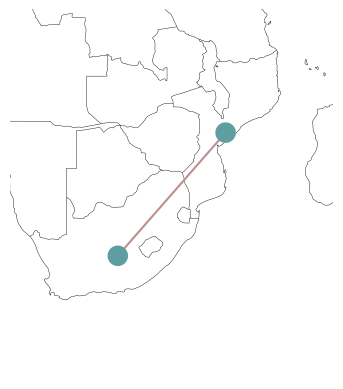

In [17]:
n.plot(bus_sizes=1, margin=1);

## Optimisation

With all input data transferred into PyPSA's data structure, we can now build and run the resulting optimisation problem. In PyPSA, building, solving and retrieving results from the optimisation model is contained in a single function call `n.optimize()`. This function optimises dispatch and investment decisions for least cost.

The `n.optimize()` function can take a variety of arguments. The most relevant for the moment is the choice of the solver. We already know some solvers from the introduction to `linopy` (e.g. "highs" and "gurobi"). They need to be installed on your computer, to use them here!

In [18]:
n.optimize(solver_name="highs")

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.13s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 6 primals, 14 duals
Objective: 1.26e+06
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper were not assigned to the network.


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-oe4l426c has 14 rows; 6 cols; 19 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [3e+01, 8e+01]
  Bound   [0e+00, 0e+00]
  RHS     [5e+02, 4e+04]
Presolving model
1 rows, 3 cols, 3 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-14); columns 0(-6); nonzeros 0(-19) - Reduced to empty
Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-oe4l426c
Model status        : Optimal
Objective value     :  1.2600000000e+06
P-D objective error :  0.0000000000e+00
HiGHS run time      :          0.00


('ok', 'optimal')

Let's have a look at the results.

Since the power flow and dispatch are generally time-varying quantities, these are stored in a different location than e.g. `n.generators`. They are stored in `n.generators_t`. Thus, to find out the dispatch of the generators, run

In [19]:
n.generators_t.p

name,MZ hydro,SA coal,SA wind,SA gas,SA oil
snapshot,,,,,
now,1150.0,35000.0,3000.0,3500.0,-0.0


or if you prefer it in relation to the generators nominal capacity

In [20]:
n.generators_t.p / n.generators.p_nom

name,MZ hydro,SA coal,SA wind,SA gas,SA oil
snapshot,,,,,
now,0.958333,1.0,1.0,0.4375,-0.0


You see that the time index has the value 'now'. This is the default index when no time series data has been specified and the network only covers a single state (e.g. a particular hour). 

Similarly you will find the power flow in transmission lines at

In [21]:
n.lines_t.p0

name,SA-MZ
snapshot,
now,-500.0


In [22]:
n.lines_t.p1

name,SA-MZ
snapshot,
now,500.0


The `p0` will tell you the flow from `bus0` to `bus1`. `p1` will tell you the flow from `bus1` to `bus0`.

What about the shadow prices?

In [23]:
n.buses_t.marginal_price

name,SA,MZ
snapshot,,
now,60.0,-0.0


## Basic network plotting

For plotting PyPSA network, we're going use matplotlib and cartopy to plot the maps.

In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

PyPSA has a built-in plotting function based on `matplotlib`, ....

{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x177c9f390>},
 'branches': {'Line': <matplotlib.collections.LineCollection at 0x177c9f4d0>},
 'flows': {}}

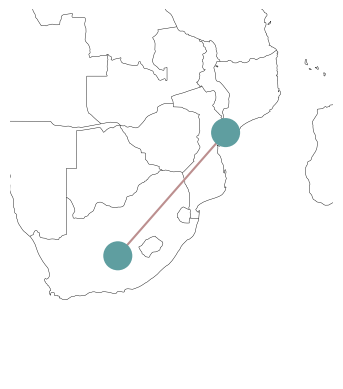

In [25]:
n.plot(margin=1, bus_sizes=2)

Since we have provided `x` and `y` coordinates for our buses, `n.plot()` will try to plot the network on a map by default. Of course, there's an option to deactivate this behaviour:

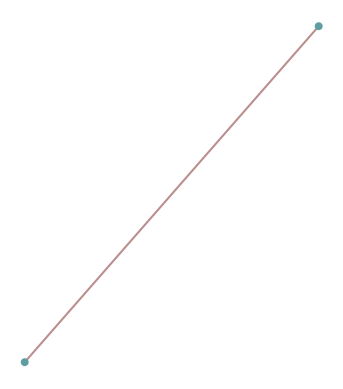

In [26]:
n.plot(geomap=False);

The `n.plot()` function has a variety of styling arguments to tweak the appearance of the buses, the lines and the map in the background:

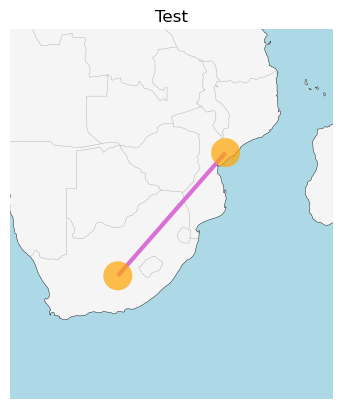

In [27]:
n.plot(
    margin=1,
    bus_sizes=2,
    bus_colors="orange",
    bus_alpha=0.7,
    geomap_color=True,
    line_colors="orchid",
    line_widths=3,
    title="Test",
);

Just like with `geopandas` we can also control the projection of the network plot:

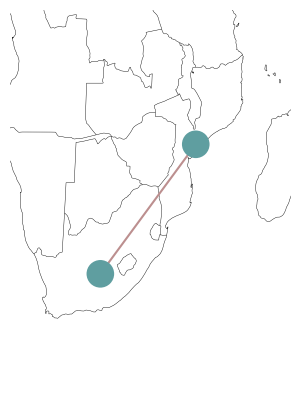

In [28]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.EqualEarth())

n.plot(ax=ax, margin=1, bus_sizes=2);

We can use the `bus_sizes` argument of `n.plot()` to display the regional distribution of load. First, we calculate the total load per bus:

In [29]:
s = n.loads.groupby("bus").p_set.sum() / 1e4

In [30]:
s

bus
MZ    0.065
SA    4.200
Name: p_set, dtype: float64

The resulting `pandas.Series` we can pass to `n.plot(bus_sizes=...)`:

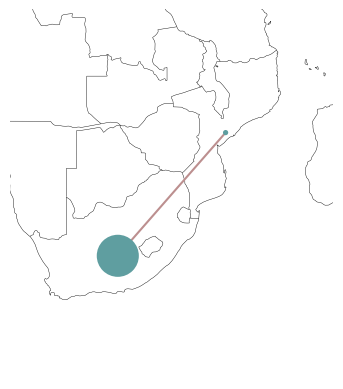

In [31]:
n.plot(margin=1, bus_sizes=s);

The important point here is, that `s` needs to have entries for all buses, i.e. its index needs to match `n.buses.index`.

The `bus_sizes` argument of `n.plot()` can be even more powerful. It can produce pie charts, e.g. for the mix of electricity generation at each bus.

The dispatch of each generator, we can find at:

In [32]:
n.generators_t.p.loc["now"]

name
MZ hydro     1150.0
SA coal     35000.0
SA wind      3000.0
SA gas       3500.0
SA oil         -0.0
Name: now, dtype: float64

If we group this by the **bus** and **carrier**...

In [33]:
s = n.generators_t.p.loc["now"].groupby([n.generators.bus, n.generators.carrier]).sum()

... we get a multi-indexed `pandas.Series` ...

In [34]:
s

bus  carrier
MZ   hydro       1150.0
SA   coal       35000.0
     gas         3500.0
     oil            0.0
     wind        3000.0
Name: now, dtype: float64

... which we can pass to `n.plot(bus_sizes=...)`:

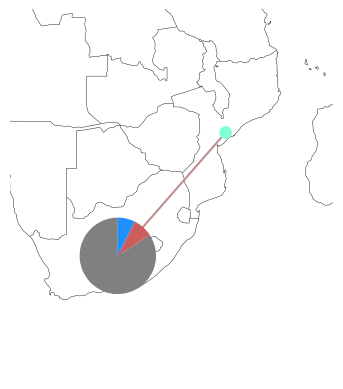

In [35]:
n.plot(margin=1, bus_sizes=s / 3000);

**How does this magic work?** The plotting function will look up the colors specified in `n.carriers` for each carrier and match it with the second index-level of `s`.

## Modifying networks

Modifying data of components in an existing PyPSA network is as easy as modifying the entries of a `pandas.DataFrame`. For instance, if we want to reduce the cross-border transmission capacity between South Africa and Mozambique, we'd run:

In [36]:
n.lines.loc["SA-MZ", "s_nom"] = 400

In [37]:
n.lines

,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt,v_nom
name,,,,,,,,,,,,,,,,,,,,,
SA-MZ,SA,MZ,,1.0,1.0,0.0,0.0,400.0,0.0,False,...,inf,0,0.000006,0.000006,0.0,0.0,0.000006,0.000006,500.0,400.0


In [38]:
n.optimize(solver_name="highs")

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.01s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 6 primals, 14 duals
Objective: 1.27e+06
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper were not assigned to the network.


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-bj95r_jr has 14 rows; 6 cols; 19 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [3e+01, 8e+01]
  Bound   [0e+00, 0e+00]
  RHS     [4e+02, 4e+04]
Presolving model
1 rows, 3 cols, 3 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-14); columns 0(-6); nonzeros 0(-19) - Reduced to empty
Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-bj95r_jr
Model status        : Optimal
Objective value     :  1.2660000000e+06
P-D objective error :  0.0000000000e+00
HiGHS run time      :          0.00


('ok', 'optimal')

You can see that the production of the hydro power plant was reduced and that of the gas power plant increased owing to the reduced transmission capacity.

In [39]:
n.generators_t.p

name,MZ hydro,SA coal,SA wind,SA gas,SA oil
snapshot,,,,,
now,1050.0,35000.0,3000.0,3600.0,-0.0


## Data import and export

:::{note}
Documentation: https://pypsa.readthedocs.io/en/latest/import_export.html.
:::

You may find yourself in a need to store PyPSA networks for later use. Or, maybe you want to import the genius PyPSA example that someone else uploaded to the web to explore.

PyPSA can be stored as `netCDF` (`.nc`) file or as a folder of `CSV` files.

* `netCDF` files have the advantage that they take up less space than `CSV` files and are faster to load.
* `CSV` might be easier to use with `Excel`.

In [40]:
n.export_to_csv_folder("tmp")

INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to 'tmp contains: generators, carriers, loads, lines, buses, sub_networks


In [41]:
n_csv = pypsa.Network("tmp")

INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, lines, loads, sub_networks


In [42]:
n.export_to_netcdf("tmp.nc");

INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to 'tmp.nc contains: generators, carriers, loads, lines, buses, sub_networks


In [43]:
n_nc = pypsa.Network("tmp.nc")

INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, lines, loads, sub_networks


## The following example is optional and not cover in the course "Integrated Energy Grids"

**Dispatch problem with German SciGRID network**


[SciGRID](https://www.scigrid.de/pages/general-information.html) is a project that provides an open reference model of the European transmission network. The network comprises time series for loads and the availability of renewable generation at an hourly resolution for January 1, 2011 as well as approximate generation capacities in 2014. This dataset is a little out of date and only intended to demonstrate the capabilities of PyPSA.

In [44]:
n = pypsa.examples.scigrid_de()

INFO:pypsa.network.io:Retrieving network data from https://github.com/PyPSA/PyPSA/raw/v1.0.7/examples/networks/scigrid-de/scigrid-de.nc.
INFO:pypsa.network.io:Imported network 'SciGrid-DE' has buses, carriers, generators, lines, loads, storage_units, transformers


There are some infeasibilities without allowing extension. Moreover, to approximate so-called $N-1$ security, we don't allow any line to be loaded above 70% of their thermal rating. $N-1$ security is a constraint that states that no single transmission line may be overloaded by the failure of another transmission line (e.g. through a tripped connection).

In [45]:
n.lines.s_max_pu = 0.7
n.lines.loc[["316", "527", "602"], "s_nom"] = 1715

Because this network includes time-varying data, now is the time to look at another attribute of `n`: `n.snapshots`. Snapshots is the PyPSA terminology for time steps. In most cases, they represent a particular hour. They can be a `pandas.DatetimeIndex` or any other list-like attributes.

In [46]:
n.snapshots

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               '2011-01-01 10:00:00', '2011-01-01 11:00:00',
               '2011-01-01 12:00:00', '2011-01-01 13:00:00',
               '2011-01-01 14:00:00', '2011-01-01 15:00:00',
               '2011-01-01 16:00:00', '2011-01-01 17:00:00',
               '2011-01-01 18:00:00', '2011-01-01 19:00:00',
               '2011-01-01 20:00:00', '2011-01-01 21:00:00',
               '2011-01-01 22:00:00', '2011-01-01 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq=None)

This index will match with any time-varying attributes of components:

In [47]:
n.loads_t.p_set.head(3)

name,1,3,4,6,7,8,9,11,14,16,...,382_220kV,384_220kV,385_220kV,391_220kV,403_220kV,404_220kV,413_220kV,421_220kV,450_220kV,458_220kV
snapshot,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,231.716206,40.613618,66.790442,196.124424,147.804142,123.671946,83.637404,73.280624,175.260369,298.900165,...,202.010114,222.695091,212.621816,77.570241,16.148970,0.092794,58.427056,67.013686,38.449243,66.752618
2011-01-01 01:00:00,221.822547,38.879526,63.938670,187.750439,141.493303,118.391487,80.066312,70.151738,167.777223,286.137932,...,193.384825,213.186609,203.543436,74.258201,15.459452,0.088831,55.932378,64.152382,36.807564,63.902460
2011-01-01 02:00:00,213.127360,37.355494,61.432348,180.390839,135.946929,113.750678,76.927805,67.401871,161.200550,274.921657,...,185.804364,204.829941,195.564769,71.347365,14.853460,0.085349,53.739893,61.637683,35.364750,61.397558


We can use simple `pandas` syntax, to create an overview of the load time series...

<Axes: xlabel='snapshot', ylabel='MW'>

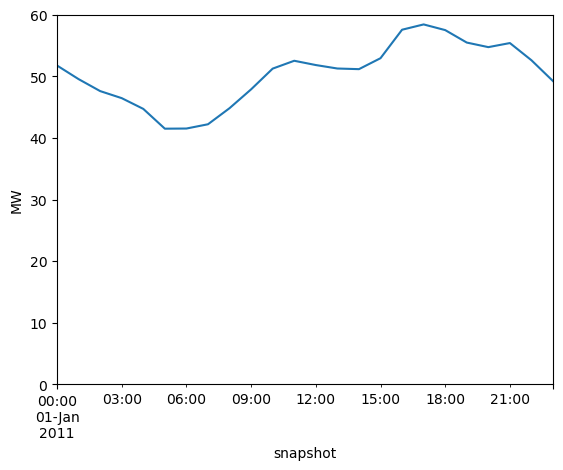

In [48]:
n.loads_t.p_set.sum(axis=1).div(1e3).plot(ylim=[0, 60], ylabel="MW")

... and the capacity factor time series:

<Axes: xlabel='snapshot', ylabel='p.u.'>

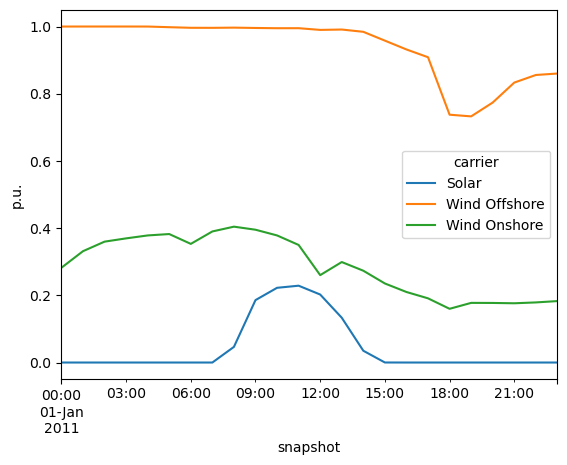

In [49]:
n.generators_t.p_max_pu.T.groupby(n.generators.carrier).mean().T.plot(ylabel="p.u.")

We can also inspect the total power plant capacities per technology...

Text(0.5, 0, 'GW')

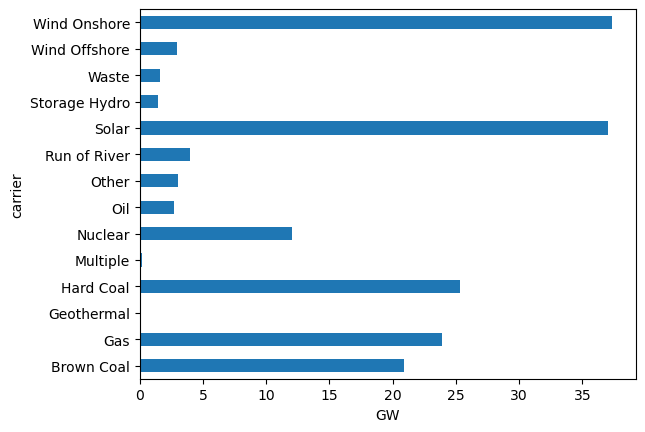

In [50]:
n.generators.groupby("carrier").p_nom.sum().div(1e3).plot.barh()
plt.xlabel("GW")

... and plot the regional distribution of loads...

In [51]:
load = n.loads_t.p_set.sum(axis=0).groupby(n.loads.bus).sum()

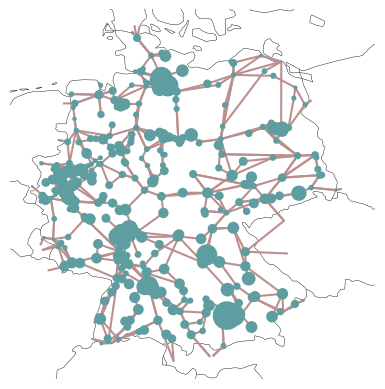

In [52]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.EqualEarth())

n.plot(
    ax=ax,
    bus_sizes=load / 2e5,
);

... and power plant capacities:

In [53]:
capacities = n.generators.groupby(["bus", "carrier"]).p_nom.sum()

For plotting we need to assign some colors to the technologies.

In [54]:
import random

carriers = list(n.generators.carrier.unique()) + list(n.storage_units.carrier.unique())
colors = ["#%06x" % random.randint(0, 0xFFFFFF) for _ in carriers]
n.add("Carrier", carriers, color=colors, overwrite=True)

Because we want to see which color represents which technology, we cann add a legend using the  `add_legend_patches` function of PyPSA.

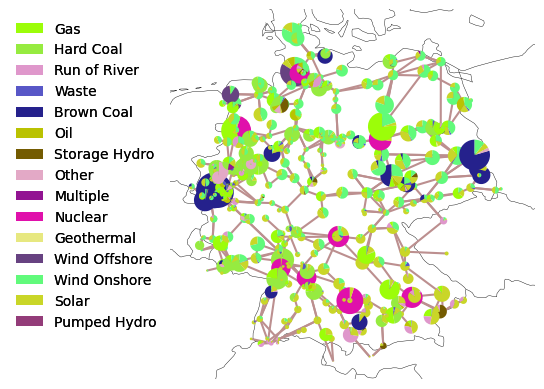

In [55]:
from pypsa.plot import add_legend_patches

fig = plt.figure()
ax = plt.axes(projection=ccrs.EqualEarth())

n.plot(
    ax=ax,
    bus_sizes=capacities / 2e4,
)

add_legend_patches(
    ax, colors, carriers, legend_kw=dict(frameon=False, bbox_to_anchor=(0, 1))
)

This dataset also includes a few hydro storage units:

In [56]:
n.storage_units.head(3)

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_nom_set,p_min_pu,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
name,,,,,,,,,,,,,,,,,,,,,
100_220kV Pumped Hydro,100_220kV,PQ,,144.5,0.0,False,0.0,inf,NaN,-1.0,...,False,NaN,False,False,6.0,0.95,0.95,0.0,0.0,0.0
114 Pumped Hydro,114,PQ,,138.0,0.0,False,0.0,inf,NaN,-1.0,...,False,NaN,False,False,6.0,0.95,0.95,0.0,0.0,0.0
121 Pumped Hydro,121,PQ,,238.0,0.0,False,0.0,inf,NaN,-1.0,...,False,NaN,False,False,6.0,0.95,0.95,0.0,0.0,0.0


So let's solve the electricity market simulation for January 1, 2011. It'll take a short moment.

In [57]:
n.optimize(solver_name="highs")

Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '413', '421', '450',
       '458'],
      dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 432.09it/s]
INFO:linopy.io: Writing time: 0.32s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-2pjl5c38 has 142968 rows; 59640 cols; 261298 nonzeros
Coefficient ranges:
  Matrix  [1e-02, 2e+02]
  Cost    [3e+00, 1e+02]
  Bound   [0e+00, 0e+00]
  RHS     [2e-11, 6e+03]
Presolving model
18737 rows, 44750 cols, 113266 nonzeros  0s
13253 rows, 39072 cols, 104687 nonzeros  0s
12725 rows, 31714 cols, 97262 nonzeros  0s
Dependent equations search running on 12697 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
12697 rows, 31673 cols, 97185 nonzeros  0s
Presolve reductions: rows 12697(-130271); columns 31673(-27967); nonzeros 97185(-164113) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 59640 primals, 142968 duals
Objective: 9.20e+06
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, Transformer-fix-s-lower, Transformer-fix-s-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance were not assigned to the network.


      17237     9.1992880405e+06 Pr: 0(0); Du: 0(9.94274e-13) 3s
      17237     9.1992880405e+06 Pr: 0(0); Du: 0(9.94274e-13) 3s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-2pjl5c38
Model status        : Optimal
Simplex   iterations: 17237
Objective value     :  9.1992880405e+06
P-D objective error :  2.3284865043e-15
HiGHS run time      :          2.90


('ok', 'optimal')

Now, we can also plot model outputs, like the calculated power flows on the network map.

In [58]:
line_loading = n.lines_t.p0.iloc[0].abs() / n.lines.s_nom / n.lines.s_max_pu * 100  # %

In [59]:
norm = plt.Normalize(vmin=0, vmax=100)

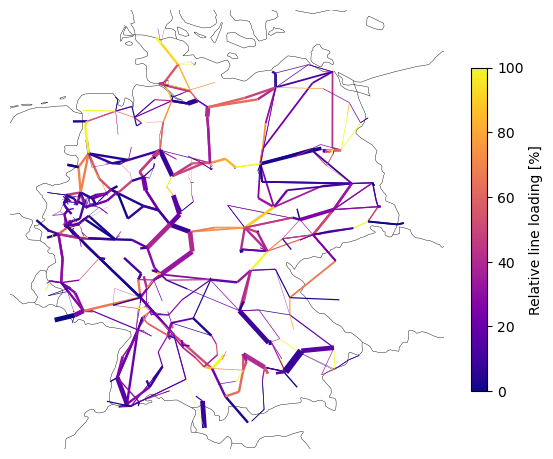

In [60]:
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection=ccrs.EqualEarth())

n.plot(
    ax=ax,
    bus_sizes=0,
    line_colors=line_loading,
    line_cmap_norm=norm,
    line_cmap="plasma",
    line_widths=n.lines.s_nom / 1000,
)

plt.colorbar(
    plt.cm.ScalarMappable(cmap="plasma", norm=norm),
    ax=ax,
    label="Relative line loading [%]",
    shrink=0.6,
)

Or plot the hourly dispatch grouped by carrier:

In [61]:
p_by_carrier = n.generators_t.p.T.groupby(n.generators.carrier).sum().T.div(1e3)

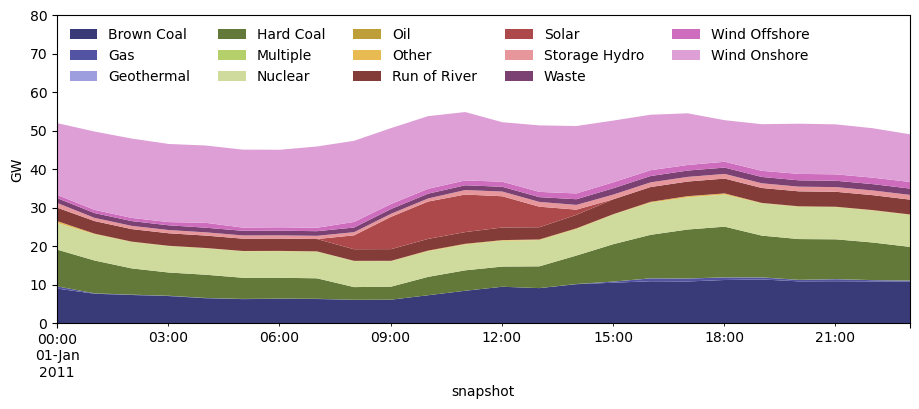

In [62]:
fig, ax = plt.subplots(figsize=(11, 4))

p_by_carrier.plot(
    kind="area",
    ax=ax,
    linewidth=0,
    cmap="tab20b",
)

ax.legend(ncol=5, loc="upper left", frameon=False)

ax.set_ylabel("GW")

ax.set_ylim(0, 80);

Or plot the aggregate dispatch of the pumped hydro storage units and the state of charge throughout the day:

Text(0, 0.5, 'MWh or MW')

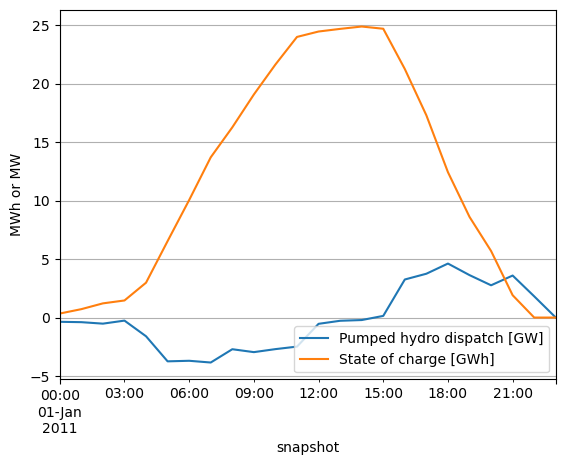

In [63]:
fig, ax = plt.subplots()

p_storage = n.storage_units_t.p.sum(axis=1).div(1e3)
state_of_charge = n.storage_units_t.state_of_charge.sum(axis=1).div(1e3)

p_storage.plot(label="Pumped hydro dispatch [GW]", ax=ax)
state_of_charge.plot(label="State of charge [GWh]", ax=ax)

ax.grid()
ax.legend()
ax.set_ylabel("MWh or MW")

Or plot the locational marginal prices (LMPs):

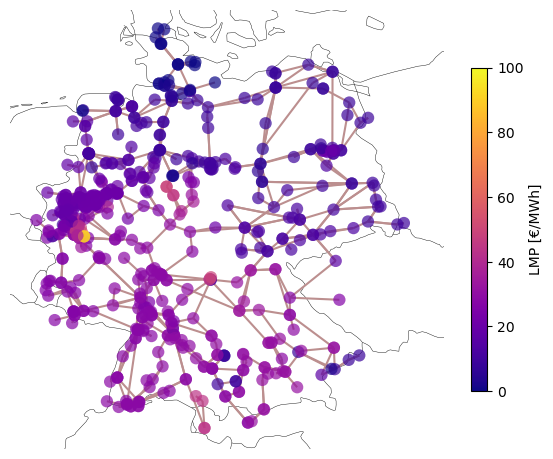

In [64]:
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection=ccrs.EqualEarth())

norm = plt.Normalize(vmin=0, vmax=100)  # €/MWh

n.plot(
    ax=ax,
    bus_colors=n.buses_t.marginal_price.mean(),
    bus_cmap="plasma",
    bus_cmap_norm=norm,
    bus_alpha=0.7,
)

plt.colorbar(
    plt.cm.ScalarMappable(cmap="plasma", norm=norm),
    ax=ax,
    label="LMP [€/MWh]",
    shrink=0.6,
)